# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("21cenario2_tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 32194 X 2229 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in range(kmin, kmax + 1, 5):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("cenario2_8M2021_tweets_pt.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 32194 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("portuguese.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 234 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 2272 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("21cenario2_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5571
K=10: Coherence=0.5556
K=15: Coherence=0.5677
K=20: Coherence=0.6064


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

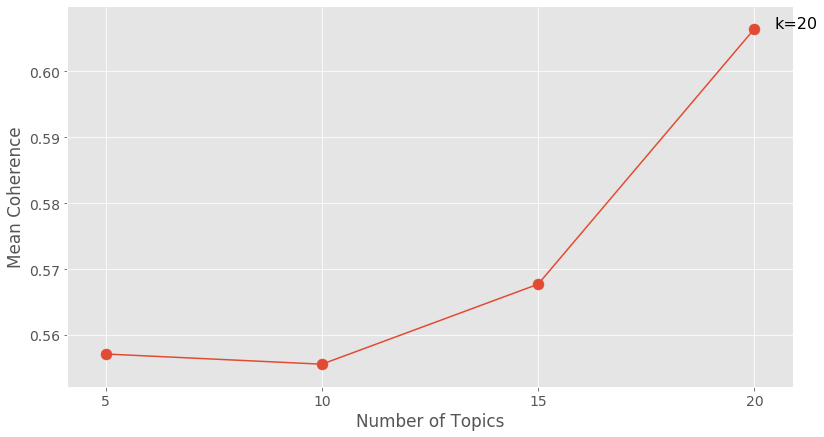

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [17]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [18]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, hoje, ser, homenagem
Topic 02: mulheres, parabens, mundo, luta, hoje
Topic 03: marco, luta, lula, hoje, ano
Topic 04: feliz, guerreiras, incriveis, dias, vcs
Topic 05: amo, tanto, amor, demais, tudo


In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, hoje, ser, homenagem, especial, parabens, continuacao, via, sobre
Topic 02: mulheres, parabens, mundo, luta, hoje, dias, vida, respeito, especial, incriveis
Topic 03: marco, luta, lula, hoje, ano, data, dias, respeito, ser, sobre
Topic 04: feliz, guerreiras, incriveis, dias, vcs, deseja, woman, mulheres, god, maravilhosas
Topic 05: amo, tanto, amor, demais, tudo, vida, deus, vcs, liam, video


In [20]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, hoje, ser, homenagem, especial, parabens, continuacao, via, sobre, presente, mae, melhor, homem, brasil
Topic 02: mulheres, parabens, mundo, luta, hoje, dias, vida, respeito, especial, incriveis, forca, direitos, guerreiras, ser, igualdade
Topic 03: marco, luta, lula, hoje, ano, data, dias, respeito, ser, sobre, ainda, brasil, flores, gente, feira
Topic 04: feliz, guerreiras, incriveis, dias, vcs, deseja, woman, mulheres, god, maravilhosas, mulher, bom, sempre, instagram, desejar
Topic 05: amo, tanto, amor, demais, tudo, vida, deus, vcs, liam, video, aqui, gente, ser, obrigada, mae


In [21]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, hoje, ser, homenagem, especial, parabens, continuacao, via, sobre, presente, mae, melhor, homem, brasil, onde, lugar, lula, quiser, vai
Topic 02: mulheres, parabens, mundo, luta, hoje, dias, vida, respeito, especial, incriveis, forca, direitos, guerreiras, ser, igualdade, sempre, fortes, aqui, homenagem, brasil
Topic 03: marco, luta, lula, hoje, ano, data, dias, respeito, ser, sobre, ainda, brasil, flores, gente, feira, vai, anos, apenas, segunda, abril
Topic 04: feliz, guerreiras, incriveis, dias, vcs, deseja, woman, mulheres, god, maravilhosas, mulher, bom, sempre, instagram, desejar, mulherada, lindas, fortes, amor, seguidoras
Topic 05: amo, tanto, amor, demais, tudo, vida, deus, vcs, liam, video, aqui, gente, ser, obrigada, mae, linda, camila, sempre, cara, lindo


# 10

In [22]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [23]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial
Topic 02: mulheres, mundo, incriveis, especial, homenagem
Topic 03: marco, lula, ano, data, brasil
Topic 04: feliz, guerreiras, dias, vcs, incriveis
Topic 05: amo, tanto, amor, demais, vida
Topic 06: ser, aqui, vai, gente, mundo
Topic 07: parabens, guerreiras, dias, vcs, mundo
Topic 08: hoje, dias, sempre, respeito, especial
Topic 09: woman, god, ariana, grande, deus
Topic 10: luta, igualdade, respeito, direitos, vida


In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial, via, presente, mae, sobre, brasil
Topic 02: mulheres, mundo, incriveis, especial, homenagem, fortes, vida, brasil, homens, dias
Topic 03: marco, lula, ano, data, brasil, feira, segunda, dias, pleno, abril
Topic 04: feliz, guerreiras, dias, vcs, incriveis, deseja, sempre, respeito, maravilhosas, bom
Topic 05: amo, tanto, amor, demais, vida, vcs, liam, deus, tudo, video
Topic 06: ser, aqui, vai, gente, mundo, tudo, mulher, pode, ter, ainda
Topic 07: parabens, guerreiras, dias, vcs, mundo, linda, amor, respeito, forca, especial
Topic 08: hoje, dias, sempre, respeito, especial, ano, tudo, forca, politico, aqui
Topic 09: woman, god, ariana, grande, deus, musica, aqui, bom, carla, juliette
Topic 10: luta, igualdade, respeito, direitos, vida, contra, sobre, sempre, queremos, violencia


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial, via, presente, mae, sobre, brasil, lula, onde, instagram, comemoracao, lugar
Topic 02: mulheres, mundo, incriveis, especial, homenagem, fortes, vida, brasil, homens, dias, trans, guerreiras, maravilhosas, fazem, outras
Topic 03: marco, lula, ano, data, brasil, feira, segunda, dias, pleno, abril, anos, apenas, ainda, flores, sobre
Topic 04: feliz, guerreiras, dias, vcs, incriveis, deseja, sempre, respeito, maravilhosas, bom, mulher, amor, desejar, instagram, mundo
Topic 05: amo, tanto, amor, demais, vida, vcs, liam, deus, tudo, video, obrigada, mae, camila, linda, lindo
Topic 06: ser, aqui, vai, gente, mundo, tudo, mulher, pode, ter, ainda, homem, nunca, orgulho, melhor, deve
Topic 07: parabens, guerreiras, dias, vcs, mundo, linda, amor, respeito, forca, especial, merecem, guerreira, fazem, boa, cada
Topic 08: hoje, dias, sempre, respeito, especial, ano, tudo, forca, politico, aqui, ainda, mae, porque, apenas, outros
Top

In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, homenagem, continuacao, especial, via, presente, mae, sobre, brasil, lula, onde, instagram, comemoracao, lugar, melhor, homem, quiser, segunda, dilma
Topic 02: mulheres, mundo, incriveis, especial, homenagem, fortes, vida, brasil, homens, dias, trans, guerreiras, maravilhosas, fazem, outras, forca, lutam, lindas, aqui, historia
Topic 03: marco, lula, ano, data, brasil, feira, segunda, dias, pleno, abril, anos, apenas, ainda, flores, sobre, homens, presente, respeito, homenagem, elegivel
Topic 04: feliz, guerreiras, dias, vcs, incriveis, deseja, sempre, respeito, maravilhosas, bom, mulher, amor, desejar, instagram, mundo, lindas, mulherada, fortes, seguidoras, desejamos
Topic 05: amo, tanto, amor, demais, vida, vcs, liam, deus, tudo, video, obrigada, mae, camila, linda, lindo, cena, amiga, musica, instagram, serio
Topic 06: ser, aqui, vai, gente, mundo, tudo, mulher, pode, ter, ainda, homem, nunca, orgulho, melhor, deve, forte, fazer, cada, sempre, quero

# 15

In [27]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [28]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via
Topic 02: mulheres, incriveis, especial, fortes, homens
Topic 03: marco, lula, ano, data, brasil
Topic 04: feliz, guerreiras, dias, vcs, incriveis
Topic 05: amo, tanto, demais, vcs, liam
Topic 06: ser, mulher, vai, pode, ter
Topic 07: parabens, guerreiras, dias, vcs, respeito
Topic 08: hoje, dias, sempre, respeito, ano
Topic 09: woman, god, ariana, grande, musica
Topic 10: luta, igualdade, respeito, direitos, contra
Topic 11: aqui, bom, tudo, sobre, video
Topic 12: mundo, melhor, brasil, tudo, lugar
Topic 13: vida, deus, amor, sempre, mae
Topic 14: homenagem, linda, video, especial, maior
Topic 15: gente, ainda, linda, coisa, vai


In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, sobre, lula, brasil, onde
Topic 02: mulheres, incriveis, especial, fortes, homens, dias, brasil, trans, maravilhosas, outras
Topic 03: marco, lula, ano, data, brasil, feira, segunda, dias, abril, pleno
Topic 04: feliz, guerreiras, dias, vcs, incriveis, deseja, sempre, respeito, maravilhosas, bom
Topic 05: amo, tanto, demais, vcs, liam, tudo, video, camila, obrigada, musica
Topic 06: ser, mulher, vai, pode, ter, tudo, dias, deve, orgulho, quiser
Topic 07: parabens, guerreiras, dias, vcs, respeito, especial, forca, guerreira, linda, boa
Topic 08: hoje, dias, sempre, respeito, ano, especial, politico, forca, tudo, outros
Topic 09: woman, god, ariana, grande, musica, carla, juliette, dizia, bom, disse
Topic 10: luta, igualdade, respeito, direitos, contra, sobre, queremos, violencia, ainda, sempre
Topic 11: aqui, bom, tudo, sobre, video, bem, demais, vcs, vou, vai
Topic 12: mundo, melhor, brasil, tudo, lugar, incriveis, 

In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, sobre, lula, brasil, onde, comemoracao, lugar, homem, quiser, mae
Topic 02: mulheres, incriveis, especial, fortes, homens, dias, brasil, trans, maravilhosas, outras, guerreiras, vida, fazem, lindas, lutam
Topic 03: marco, lula, ano, data, brasil, feira, segunda, dias, abril, pleno, anos, apenas, flores, ainda, homens
Topic 04: feliz, guerreiras, dias, vcs, incriveis, deseja, sempre, respeito, maravilhosas, bom, instagram, mulher, desejar, lindas, mulherada
Topic 05: amo, tanto, demais, vcs, liam, tudo, video, camila, obrigada, musica, amiga, cena, instagram, admiro, lindas
Topic 06: ser, mulher, vai, pode, ter, tudo, dias, deve, orgulho, quiser, forte, quero, nunca, assim, homem
Topic 07: parabens, guerreiras, dias, vcs, respeito, especial, forca, guerreira, linda, boa, fazem, mulherada, merecem, cada, brazil
Topic 08: hoje, dias, sempre, respeito, ano, especial, politico, forca, tudo, outros, apenas, porque, ainda,

In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, sobre, lula, brasil, onde, comemoracao, lugar, homem, quiser, mae, instagram, dilma, segunda, primeira, pleno
Topic 02: mulheres, incriveis, especial, fortes, homens, dias, brasil, trans, maravilhosas, outras, guerreiras, vida, fazem, lindas, lutam, historia, inspiram, pandemia, internacional, forca
Topic 03: marco, lula, ano, data, brasil, feira, segunda, dias, abril, pleno, anos, apenas, flores, ainda, homens, sobre, presente, elegivel, respeito, melhor
Topic 04: feliz, guerreiras, dias, vcs, incriveis, deseja, sempre, respeito, maravilhosas, bom, instagram, mulher, desejar, lindas, mulherada, seguidoras, fortes, desejamos, foda, via
Topic 05: amo, tanto, demais, vcs, liam, tudo, video, camila, obrigada, musica, amiga, cena, instagram, admiro, lindas, cara, mae, serio, lindo, foto
Topic 06: ser, mulher, vai, pode, ter, tudo, dias, deve, orgulho, quiser, forte, quero, nunca, assim, homem, cada, sempre, queria, faze

# 20

In [32]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [33]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via
Topic 02: mulheres, incriveis, especial, fortes, homens
Topic 03: marco, data, ano, feira, segunda
Topic 04: feliz, guerreiras, vcs, deseja, incriveis
Topic 05: amo, tanto, demais, liam, vcs
Topic 06: ser, mulher, pode, vai, ter
Topic 07: parabens, guerreiras, vcs, especial, linda
Topic 08: hoje, especial, politico, data, forca
Topic 09: woman, god, ariana, grande, musica
Topic 10: luta, direitos, igualdade, contra, violencia
Topic 11: aqui, bem, demais, video, vou
Topic 12: mundo, melhor, incriveis, lugar, forca
Topic 13: vida, deus, amor, mae, especial
Topic 14: dias, respeito, flores, igualdade, queremos
Topic 15: gente, linda, ainda, coisa, olha
Topic 16: homenagem, linda, video, especial, mae
Topic 17: tudo, faz, acima, bem, fazer
Topic 18: sempre, bom, lembrar, razao, demais
Topic 19: sobre, ainda, falar, video, fazer
Topic 20: brasil, lula, ciro, vai, dilma


In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, onde, comemoracao, lugar, quiser
Topic 02: mulheres, incriveis, especial, fortes, homens, trans, maravilhosas, outras, vida, guerreiras
Topic 03: marco, data, ano, feira, segunda, abril, anos, pleno, lula, apenas
Topic 04: feliz, guerreiras, vcs, deseja, incriveis, maravilhosas, instagram, desejar, lindas, mulherada
Topic 05: amo, tanto, demais, liam, vcs, video, camila, musica, amiga, obrigada
Topic 06: ser, mulher, pode, vai, ter, deve, orgulho, quiser, forte, cada
Topic 07: parabens, guerreiras, vcs, especial, linda, guerreira, forca, boa, mulherada, fazem
Topic 08: hoje, especial, politico, data, forca, romantico, porque, mae, vou, ainda
Topic 09: woman, god, ariana, grande, musica, carla, juliette, dizia, joao, disse
Topic 10: luta, direitos, igualdade, contra, violencia, data, diaria, forca, resistencia, viva
Topic 11: aqui, bem, demais, video, vou, vcs, deixar, fica, olha, voltou
Topic 12: mundo, melhor, incr

In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, onde, comemoracao, lugar, quiser, homem, mae, segunda, instagram, guerreira
Topic 02: mulheres, incriveis, especial, fortes, homens, trans, maravilhosas, outras, vida, guerreiras, fazem, lindas, lutam, internacional, inspiram
Topic 03: marco, data, ano, feira, segunda, abril, anos, pleno, lula, apenas, homens, ainda, lembrar, via, aniversario
Topic 04: feliz, guerreiras, vcs, deseja, incriveis, maravilhosas, instagram, desejar, lindas, mulherada, mulher, seguidoras, fortes, via, foda
Topic 05: amo, tanto, demais, liam, vcs, video, camila, musica, amiga, obrigada, instagram, cena, admiro, lindas, cara
Topic 06: ser, mulher, pode, vai, ter, deve, orgulho, quiser, forte, cada, assim, homem, queria, quero, nunca
Topic 07: parabens, guerreiras, vcs, especial, linda, guerreira, forca, boa, mulherada, fazem, cada, brazil, batalhadoras, meninas, maluf
Topic 08: hoje, especial, politico, data, forca, romantico, porque, mae, 

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, continuacao, especial, via, presente, onde, comemoracao, lugar, quiser, homem, mae, segunda, instagram, guerreira, mensagem, ontem, pix, feira, data
Topic 02: mulheres, incriveis, especial, fortes, homens, trans, maravilhosas, outras, vida, guerreiras, fazem, lindas, lutam, internacional, inspiram, direitos, historia, pandemia, forca, trabalho
Topic 03: marco, data, ano, feira, segunda, abril, anos, pleno, lula, apenas, homens, ainda, lembrar, via, aniversario, fevereiro, joao, mes, semana, marcado
Topic 04: feliz, guerreiras, vcs, deseja, incriveis, maravilhosas, instagram, desejar, lindas, mulherada, mulher, seguidoras, fortes, via, foda, desejamos, nunca, desejando, querida, cada
Topic 05: amo, tanto, demais, liam, vcs, video, camila, musica, amiga, obrigada, instagram, cena, admiro, lindas, cara, mae, foto, lindo, serio, mds
Topic 06: ser, mulher, pode, vai, ter, deve, orgulho, quiser, forte, cada, assim, homem, queria, quero, nunca, incrivel, forca